# Training a Simple CNN in Keras

## Initial Setup

In [1]:
from __future__ import division
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load Images into a Matrix

In [75]:
base_dir = 'square_images128'
image_width = 128
image_height = 128

classes = ['daffodil',  'snowdrop', 'lily_valley', 'bluebell', 'crocus', 'iris', 
           'tigerlily', 'tulip', 'fritillary', 'sunflower', 'daisy', 'colts_foot', 
           'dandelion', 'cowslip', 'buttercup', 'windflower', 'pansy']

class_dict = { class_name: index for (index, class_name) in enumerate(classes)}


folders = os.listdir(base_dir)
folders = [folder for folder in folders if folder != '.DS_Store']

xs = []
ys = []

for folder_name in folders:
    # We look up the class number based on the name of the folder the image is in.
    # This maps a folder name like 'daffodil' to a class number like 0.
    class_index = class_dict[folder_name]
    
    file_names = os.listdir(base_dir + '/' + folder_name)
    file_names = [name for name in file_names if name != '.DS_Store']
    
    X = np.empty([len(file_names), image_width, image_height, 3])
    y = []
    
    for (index, file_name) in enumerate(file_names):
        file_path = base_dir + '/' + folder_name + '/' + file_name
        #print(file_path)
        I = np.array(Image.open(file_path))
        X[index] = I
        y.append(class_index)
    
    X_combined = X
    y_array = np.array(y)
    xs.append(X_combined)
    ys.append(y_array)
    
    
X_all = np.concatenate(xs)
y_all = np.concatenate(ys)

print(X_all.shape)
print(y_all.shape)

(1360, 128, 128, 3)
(1360,)


In [76]:
# Randomly shuffle the input images and labels (IN THE SAME RANDOM ORDER SO THEY ARE STILL CORRELATED)
rng_state = np.random.get_state()
np.random.shuffle(X_all)
np.random.set_state(rng_state)
np.random.shuffle(y_all)

In [77]:
# Split the data into training/validation/testing segments
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.25)

"""
# 20% of training data reserved for the validation set
# Here we're using a fixed validation set, not doing cross-validation
percentage_validation = 0.20

num_total = X_train.shape[0]
num_validation = int(num_total * percentage_validation)
num_training = num_total - num_validation

# Our validation set will be num_validation points from the original training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_training points from the original training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
"""

"\n# 20% of training data reserved for the validation set\n# Here we're using a fixed validation set, not doing cross-validation\npercentage_validation = 0.20\n\nnum_total = X_train.shape[0]\nnum_validation = int(num_total * percentage_validation)\nnum_training = num_total - num_validation\n\n# Our validation set will be num_validation points from the original training set.\nmask = range(num_training, num_training + num_validation)\nX_val = X_train[mask]\ny_val = y_train[mask]\n\n# Our training set will be the first num_training points from the original training set.\nmask = range(num_training)\nX_train = X_train[mask]\ny_train = y_train[mask]\n"

In [78]:
# Normalize the data: subtract the mean image
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
#X_val -= mean_image
X_test -= mean_image

# Transpose so that channels come first
X_train = X_train.transpose(0, 3, 1, 2).copy()
#X_val = X_val.transpose(0, 3, 1, 2).copy()
X_test = X_test.transpose(0, 3, 1, 2).copy()

print(X_train.shape)
#print(X_val.shape)
print(X_test.shape)

(1020, 3, 128, 128)
(340, 3, 128, 128)


In [79]:
from __future__ import absolute_import
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils, generic_utils
from six.moves import range

'''
    Train a (fairly simple) deep CNN on the CIFAR10 small images dataset.

    GPU run command:
        THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python cifar10_cnn.py

    It gets down to 0.65 test logloss in 25 epochs, and down to 0.55 after 50 epochs.
    (it's still underfitting at that point, though).

    Note: the data was pickled with Python 2, and some encoding issues might prevent you
    from loading it in Python 3. You might have to load it in Python 2,
    save it in a different format, load it in Python 3 and repickle it.
'''

batch_size = 16
num_classes = 17
num_epochs = 30

# input image dimensions
img_rows, img_cols = 128, 128
# the images are RGB
img_channels = 3

# the data, shuffled and split between train and test sets
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

print(Y_train[0])


model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='full',
                        input_shape=(img_channels, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='full'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# let's train the model using SGD + momentum (how original).
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#adagrad = Adagrad(lr=0.01, epsilon=1e-6)
adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=adadelta)

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

history = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=num_epochs, validation_split=0.1, show_accuracy=True, verbose=1)
(loss, accuracy) = model.evaluate(X_test, Y_test, batch_size=batch_size, show_accuracy=True)
print(history)
print('Test score:', loss)
print('Test accuracy:', accuracy)

X_train shape: (1020, 3, 128, 128)
1020 train samples
340 test samples
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
Train on 918 samples, validate on 102 samples
Epoch 1/30
918/918 [==============================] - 10s - loss: 2.8585 - acc: 0.1362 - val_loss: 2.3778 - val_acc: 0.2941
Epoch 2/30
918/918 [==============================] - 10s - loss: 2.2384 - acc: 0.2484 - val_loss: 2.2310 - val_acc: 0.3137
Epoch 3/30
918/918 [==============================] - 10s - loss: 1.8949 - acc: 0.3529 - val_loss: 1.6030 - val_acc: 0.4608
Epoch 4/30
918/918 [==============================] - 10s - loss: 1.6468 - acc: 0.4444 - val_loss: 1.5191 - val_acc: 0.4608
Epoch 5/30
918/918 [==============================] - 11s - loss: 1.4687 - acc: 0.5033 - val_loss: 1.3075 - val_acc: 0.5980
Epoch 6/30
918/918 [==============================] - 10s - loss: 1.2274 - acc: 0.5959 - val_loss: 1.6173 - val_acc: 0.4314
Epoch 7/30
918/918 [==============================] - 10s - loss: 1.0

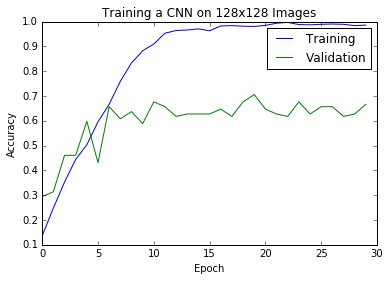

In [80]:
training_accuracies = history.history['acc']
validation_accuracies = history.history['val_acc']

plt.plot(training_accuracies)
plt.plot(validation_accuracies)
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training a CNN on 128x128 Images')